In [1]:
from IPython.core.display import display, HTML
from string import Template
import pandas as pd
import json, random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def open_json(filename):
    with open(filename, "r", encoding="utf-8") as read_file:
        data = json.load(read_file)
    return data

In [3]:
class Person:
    def __init__(self, dictionary):
        self.id = dictionary['id']
        self.name = dictionary['name']
        self.gender = dictionary['gender']
        if 'pids' in dictionary.keys():
            self.pids = dictionary['pids']
        else:
            self.pids = []
        if 'mid' in dictionary.keys():
            self.mid = dictionary['mid']
        else:
            self.mid = -1
        if 'fid' in dictionary.keys():
            self.fid = dictionary['fid']
        else:
            self.fid = -1
        self.cids = []
        self.rank = -1


    def __repr__(self):
        result = str(self.id) + ', ' + self.name + ', ' + self.gender
        result += ', ' + str(self.pids)
        result += ', ' + str(self.mid)
        result += ', ' + str(self.fid)
        result += ', ' + str(self.cids)
        result += ', ' + str(self.rank)
        return '{' + result + '}'

In [4]:
class Family:
    def __init__(self, id, sid1, sid2, cids):
        self.id = id
        self.sid1 = sid1
        self.sid2 = sid2
        self.cids = cids

    def __repr__(self):
        result = str(self.id) + ', ' + str(self.sid1) + ', ' + str(self.sid2) + ', ' + str(self.cids)
        return '{' + result + '}'

    def __eq__(self, other):
        if self.sid1 == other.sid1 or self.sid2 == other.sid2 or self.cids == other.cids:
            return True
        else:
            return False


In [5]:
class FamilyTree:
    def __init__(self, tree_list):
        self.tree = {}
        if type(tree_list) is list:
            for node in tree_list:
                if type(node) is dict:
                    person = Person(node)
                    self.tree.update({person.id: person})
                else:
                    print("List must contains dict!")
        else:
            print("Tree must be list!")
        self.__add_children()
        self.__add_rank()
        self.families = {}
        self.__add_families()

    def __add_children(self):
        result = self.tree
        for i in self.tree:
            if self.tree[i].mid != -1:
                result[self.tree[i].mid].cids.append(self.tree[i].id)
            if self.tree[i].fid != -1:
                result[self.tree[i].fid].cids.append(self.tree[i].id)
        self.tree = result

    def __add_rank(self):
        result = self.tree
        def add_rank_node(node, rank):
            if node.rank == -1:
                node.rank = str(rank)
                for n in node.pids:
                    add_rank_node(result[n], rank)
            else:
                rank+=1
                for n in node.cids:
                    add_rank_node(result[n], rank)
        add_rank_node(result[1], 0)
        self.tree = result

    def __add_families(self):
        i = 0
        for person in self.tree.values():
            for pid in person.pids:
                family = Family( 'f' + str(i), person.id, pid, list(set(person.cids) & set(self.tree[pid].cids)))
                if family not in self.families.values():
                    self.families.update({family.id:family})
                    i+=1

    def get_all_attr(self, attr_name):
        result = []
        for person in self.tree.values():
            result.append(getattr(person, attr_name))
        return result

    def get_dataframe(self):
        df_dict = {}
        for attr in ['id', 'name', 'gender', 'pids', 'mid', 'fid', 'cids', 'rank']:
            df_dict.update({attr:self.get_all_attr(attr)})
        df = pd.DataFrame.from_dict(df_dict)
        df.set_index('id', inplace=True)
        return df

    def get_persons_df(self):
        df_dict = {}
        for attr in ['id', 'name', 'gender', 'rank']:
            df_dict.update({attr:self.get_all_attr(attr)})
        df = pd.DataFrame.from_dict(df_dict)
        df.set_index('id', inplace=True)
        return df

    def get_links_df(self):
        df_dict = {}
        for attr in ['id', 'pids', 'cids']:
            df_dict.update({attr:self.get_all_attr(attr)})
        df = pd.DataFrame.from_dict(df_dict)
        df.set_index('id', inplace=True)
        return df

    def get_links_pair_df(self):
        df_dict = {'source_id':[], 'target_id':[], 'color':[]}
        for person in self.tree.values():
            for pid in person.pids:
                if self.tree[pid].id not in df_dict['source_id'] and person.id not in df_dict['target_id']:
                    df_dict['source_id'].append(person.id)
                    df_dict['target_id'].append(self.tree[pid].id)
                    df_dict['color'].append('green')
            for cid in person.cids:
                df_dict['source_id'].append(person.id)
                df_dict['target_id'].append(self.tree[cid].id)
                df_dict['color'].append('blue')
        df = pd.DataFrame.from_dict(df_dict)
        return df

    def get_links_pair_families_df(self):
        df_dict = {'source_id':[], 'target_id':[], 'color':[]}

        for family in self.families.values():
            df_dict['source_id'].append(family.sid1)
            df_dict['target_id'].append(family.id)
            df_dict['color'].append('green')
            df_dict['source_id'].append(family.sid2)
            df_dict['target_id'].append(family.id)
            df_dict['color'].append('green')
            for cid in family.cids:
                df_dict['source_id'].append(family.id)
                df_dict['target_id'].append(cid)
                df_dict['color'].append('blue')

        df = pd.DataFrame.from_dict(df_dict)
        return df


In [6]:
family_tree = FamilyTree(open_json('data/tree3.json'))
family_tree.tree

{1: {1, Михаил Федорович, male, [2], -1, -1, [3], 0},
 2: {2, Евдокия Лукьяновна Стрешнева, female, [1], -1, -1, [3], 0},
 3: {3, Алексей Михайлович, male, [4, 5], 1, 2, [6, 7, 8, 18], 1},
 4: {4, Мария Ильинична Милославская, female, [3], -1, -1, [6, 7, 8], 1},
 5: {5, Наталья Кирилловна Нарышкина, female, [3], -1, -1, [18], 1},
 6: {6, Федор Алексеевич, male, [9], 3, 4, [], 2},
 7: {7, Софья Алексеевна, female, [], 3, 4, [], 2},
 8: {8, Иоанн V Алексеевич, male, [10], 3, 4, [11, 12], 2},
 9: {9, Марфа Матвеевна Апраксина, female, [6], -1, -1, [], 2},
 10: {10, Прасковья Федоровна Салтыкова, female, [8], -1, -1, [11, 12], 2},
 11: {11, Екатерина Иоановна, female, [13], 8, 10, [15], 3},
 12: {12, Анна Иоановна, female, [14], 8, 10, [], 3},
 13: {13, Карл Леопольд Мекленбург-Шверенский, male, [11], -1, -1, [15], 3},
 14: {14, Фридрих Вильгельм Курляндский, male, [12], -1, -1, [], 3},
 15: {15, Анна Леопольдовна, female, [16], 13, 11, [17], 4},
 16: {16, Антон Ульрих Брауншвейг-Вольфенбю

In [7]:
family_tree.get_dataframe()

,name,gender,pids,mid,fid,cids,rank
id,,,,,,,
1,Михаил Федорович,male,[2],-1,-1,[3],0
2,Евдокия Лукьяновна Стрешнева,female,[1],-1,-1,[3],0
3,Алексей Михайлович,male,"[4, 5]",1,2,"[6, 7, 8, 18]",1
4,Мария Ильинична Милославская,female,[3],-1,-1,"[6, 7, 8]",1
5,Наталья Кирилловна Нарышкина,female,[3],-1,-1,[18],1
6,Федор Алексеевич,male,[9],3,4,[],2
7,Софья Алексеевна,female,[],3,4,[],2
8,Иоанн V Алексеевич,male,[10],3,4,"[11, 12]",2
9,Марфа Матвеевна Апраксина,female,[6],-1,-1,[],2


In [8]:
family_tree.get_persons_df()

,name,gender,rank
id,,,
1,Михаил Федорович,male,0
2,Евдокия Лукьяновна Стрешнева,female,0
3,Алексей Михайлович,male,1
4,Мария Ильинична Милославская,female,1
5,Наталья Кирилловна Нарышкина,female,1
6,Федор Алексеевич,male,2
7,Софья Алексеевна,female,2
8,Иоанн V Алексеевич,male,2
9,Марфа Матвеевна Апраксина,female,2


In [9]:
family_tree.get_links_df()

,pids,cids
id,,
1,[2],[3]
2,[1],[3]
3,"[4, 5]","[6, 7, 8, 18]"
4,[3],"[6, 7, 8]"
5,[3],[18]
6,[9],[]
7,[],[]
8,[10],"[11, 12]"
9,[6],[]


In [10]:
family_tree.get_links_pair_df()

,source_id,target_id,color
0,1,2,green
1,1,3,blue
2,2,3,blue
3,3,6,blue
4,3,7,blue
5,3,8,blue
6,3,18,blue
7,4,6,blue
8,4,7,blue
9,4,8,blue


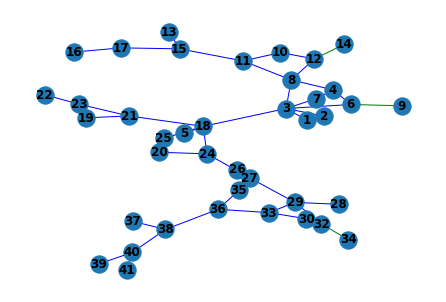

In [11]:
G = nx.from_pandas_edgelist(family_tree.get_links_pair_df(),
                            source='source_id',
                            target='target_id',
                            edge_attr='color')
nx.draw(G, with_labels=True, font_weight='bold', edge_color=list(nx.get_edge_attributes(G,'color').values()))

In [12]:
family_tree.families

{'f0': {f0, 1, 2, [3]},
 'f1': {f1, 3, 4, [8, 6, 7]},
 'f2': {f2, 5, 3, [18]},
 'f3': {f3, 6, 9, []},
 'f4': {f4, 8, 10, [11, 12]},
 'f5': {f5, 11, 13, [15]},
 'f6': {f6, 15, 16, [17]},
 'f7': {f7, 18, 19, [21]},
 'f8': {f8, 20, 18, [24, 25]},
 'f9': {f9, 21, 22, [23]},
 'f10': {f10, 24, 26, [27]},
 'f11': {f11, 27, 28, [29]},
 'f12': {f12, 29, 30, [32, 33]},
 'f13': {f13, 33, 35, [36]},
 'f14': {f14, 36, 37, [38]},
 'f15': {f15, 38, 39, [40]}}

In [13]:
family_tree.get_links_pair_families_df()

,source_id,target_id,color
0,1,f0,green
1,2,f0,green
2,f0,3,blue
3,3,f1,green
4,4,f1,green
5,f1,8,blue
6,f1,6,blue
7,f1,7,blue
8,5,f2,green
9,3,f2,green


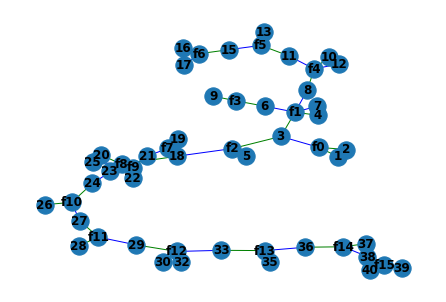

In [14]:
G = nx.from_pandas_edgelist(family_tree.get_links_pair_families_df(),
                            source='source_id',
                            target='target_id',
                            edge_attr='color')
nx.draw(G, with_labels=True, font_weight='bold', edge_color=list(nx.get_edge_attributes(G,'color').values()))